# Fruits fresh and rotten for classification

1. introducció

Utiltzare la llibreria Keras de tensorflow per el tractament de les dades ja que tinc carpetes amb imatges girades en comptes de un csv com estaba habituat. He treballat amb aquesta llibreria a la assignatura de visio per computador l'any passat y pel que he vist Tensorflow no esta Suportat en la versió de python 3.11 per lo que he tingut que pasar a 3.10 per si voleu executar el codi vosaltres.

In [1]:
#llibreries a utilitzar
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import svm
from sklearn.metrics import accuracy_score, recall_score
import time
import seaborn as sns
import cv2

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.losses import sparse_categorical_crossentropy
from keras.optimizers import Adam
from sklearn.model_selection import KFold
from keras.utils import to_categorical


In [3]:
TRAIN_PATH = 'data/dataset/train/'
TEST_PATH = 'data/dataset/test/'

In [49]:
labels = []
imnames = []
imlabels = []
for class_ in os.listdir(TEST_PATH):
    labels.append(class_)
    for im in os.listdir(TEST_PATH+str(class_)):
        imnames.append(TEST_PATH+str(class_)+"/"+str(im))
        imlabels.append(class_)
NUM_LABELS = len(labels)
NUM_IMG = len(imlabels)

print(labels)

['freshapples', 'freshbanana', 'freshoranges', 'rottenapples', 'rottenbanana', 'rottenoranges']


In [50]:
#data augmentation
train=ImageDataGenerator(rescale=1./255, validation_split = 0.1)
test=ImageDataGenerator(rescale=1/255.0)
BATCH_SIZE=64
IMG_SHAPE=(240,240)

In [51]:
train_dataset = train.flow_from_directory(batch_size=BATCH_SIZE,directory=TEST_PATH,shuffle=True,classes=labels,target_size=IMG_SHAPE, subset="training",class_mode='categorical')
val_dataset = train.flow_from_directory(batch_size=BATCH_SIZE,directory=TEST_PATH,shuffle=True,classes=labels,target_size=IMG_SHAPE, subset="validation",class_mode='categorical')

Found 2430 images belonging to 6 classes.
Found 268 images belonging to 6 classes.


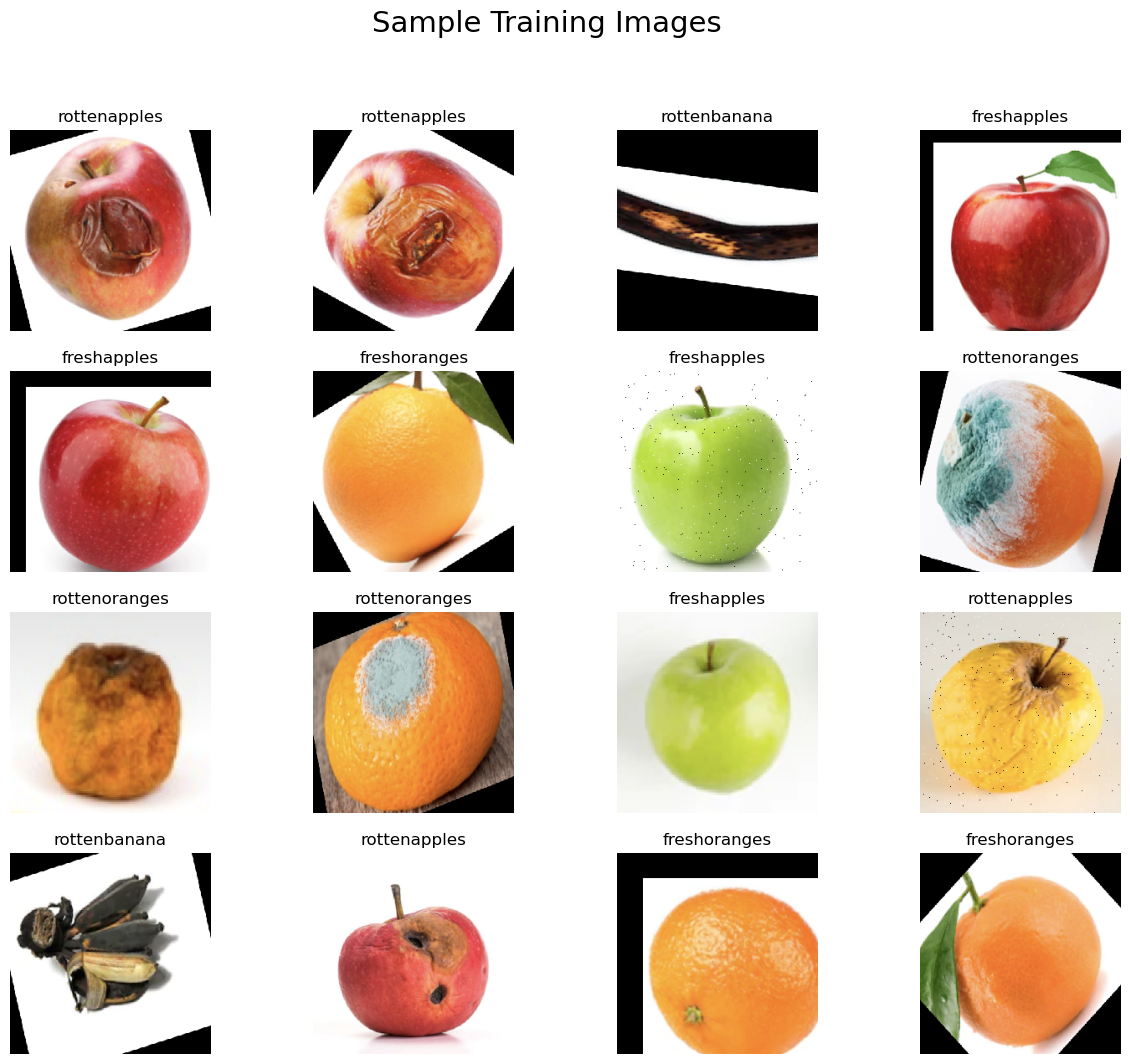

In [52]:
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(15, 12))
idx = 0
for i in range(4):
    for j in range(4):
        label = labels[np.argmax(train_dataset[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_dataset[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

# plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

Un cop hem llegit les dades veiem que en train_dataset[X][0] tenim els valors de les imatges per tal de ser impresas amb plt, en train_dataset[X][1] un array que ens indica a quina clase / carpeta pertany la fruita en questió provare les dades amb la carpeta test per tal de prevenir un cas de overflow ja que hi ha 10000 imatges en train y 2500 nomes en test. La variable X arriba fins al valor de dividir el numero de imatges/BATCH_SIZE en la funció ImageDataGenerator que ens realitza un Data augmentation a les meves dades.

Les diferents variables que tenim son la categoria a la que pertany la nostre imatge que sera 1 si pertany i si no pertany en aquella columna hi haura un valor 0, el nostre objectius es detectar si una fruita esta en bones condicions o no per molt que hi hagi una foto amb la fruita girada o no.

# 2. aplicar models

CROSSVALIDATION

In [13]:
# Define the model architecture , (64, 240, 240, 3)shape dataset

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(240,240,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(NUM_LABELS, activation='softmax'))

In [14]:
# Define the K-fold Cross Validator
k_folds = 6
kfold = KFold(n_splits=k_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
print(kfold)

KFold(n_splits=6, random_state=None, shuffle=True)


per poder aplicar un K-Fold Crossvalidation vaig pensar en dividir el train i realitzar un .flow_from_directory() a cada iteracio a partir del train incial que ja te el ImageDataGenerator aplicat.

In [18]:
#necesitem valors numerics per tal de poder aplicar flow
aux1 = []
aux2 = []
for i,im in enumerate(imnames):
    image = cv2.imread(im)
    aux1.append(np.array(image.flatten(), dtype=object))
    aux2.append(np.where(labels==imlabels[i])[0][0])
X = np.array(aux1, dtype=object)
y = np.array(aux2)

[array([0, 0, 0, ..., 0, 0, 0], dtype=object)
 array([0, 0, 0, ..., 0, 0, 0], dtype=object)
 array([0, 0, 0, ..., 0, 0, 0], dtype=object) ...
 array([255, 255, 255, ..., 255, 255, 255], dtype=object)
 array([100, 125, 178, ..., 107, 85, 91], dtype=object)
 array([255, 255, 255, ..., 255, 255, 255], dtype=object)]


In [23]:
print(len(X))

2698


In [45]:

acc = []
i =0
for train_index, val_index in kfold.split(X):
    
    
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    print("=========================================")
    print("====== K Fold Validation step => %d/%d =======" % (fold_no,k_folds))
    print("=========================================")
    
    print(X_val)
    
    val_gen = train.flow(x=X_val.flatten(), y=y_val,batch_size=BATCH_SIZE)
    train_gen = train.flow(x=X_train, y=y_train, batch_size=BATCH_SIZE) #tienen que ser valores numericos
    
    
    model.fit(generator=train_gen, validation_data=val_gen)
    
    _,accuracy=model.evaluate(val_data, verbose=0)
    fold_no = fold_no + 1
    acc.append(accuracy)
    
print("Average accuracy:", sum(accuracies) / len(accuracies))

====== K Fold Validation step => 1/6 =======
[array([0, 0, 0, ..., 0, 0, 0], dtype=object)
 array([0, 0, 0, ..., 0, 0, 0], dtype=object)
 array([0, 0, 0, ..., 0, 0, 0], dtype=object)
 array([0, 0, 0, ..., 0, 0, 0], dtype=object)
 array([0, 0, 0, ..., 0, 0, 0], dtype=object)
 array([0, 0, 0, ..., 0, 0, 0], dtype=object)
 array([0, 0, 0, ..., 0, 0, 0], dtype=object)
 array([0, 0, 0, ..., 0, 0, 0], dtype=object)
 array([0, 0, 0, ..., 0, 0, 0], dtype=object)
 array([0, 0, 0, ..., 0, 0, 0], dtype=object)
 array([0, 0, 0, ..., 0, 0, 0], dtype=object)
 array([0, 0, 0, ..., 0, 0, 0], dtype=object)
 array([0, 0, 0, ..., 0, 0, 0], dtype=object)
 array([0, 0, 0, ..., 0, 0, 0], dtype=object)
 array([0, 0, 0, ..., 0, 0, 0], dtype=object)
 array([0, 0, 0, ..., 0, 0, 0], dtype=object)
 array([0, 0, 0, ..., 0, 0, 0], dtype=object)
 array([0, 0, 0, ..., 0, 0, 0], dtype=object)
 array([0, 0, 0, ..., 0, 0, 0], dtype=object)
 array([0, 0, 0, ..., 0, 0, 0], dtype=object)
 array([0, 0, 0, ..., 0, 0, 0], dty

ValueError: setting an array element with a sequence.

In [31]:
print(cv2.imread(imnames[0]).flatten())

[0 0 0 ... 0 0 0]
